In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from default_constants import *
from ECE_mechanism.voltammogram_ECE_no_plot import CSV_ECE_ox
from ECE_mechanism.plot_voltammogram_ECE import extract_expe_like_CSV
from scipy.optimize import minimize

def plot_experimental_data(folder_name):
    directory = folder_name
    for filename in os.listdir(directory):
        if filename.endswith(".txt"): 
            path = os.path.join(directory, filename)
            df = pd.read_csv(path, delimiter = ';', decimal = ',')
            Potential = df['Potential applied (V)'].to_numpy()
            Intensity = df['WE(1).Current (A)'].to_numpy()
            plt.plot(Potential, Intensity, label = path)
            continue
        else:
            continue
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    
def find_experimental_potentials_CSV(file_name):
    df = pd.read_csv(file_name, delimiter = ';', decimal = ',')
    Potential = df['Potential applied (V)'].to_numpy()
    Time      = df['Time (s)'].to_numpy()
    E_ox = max(Potential)
    E_red = min(Potential)
    E_start = Potential[0]
    Delta_E = Potential[1] - Potential[0]
    v = Delta_E/(Time[1] - Time[0])
    return(E_ox, E_red, 0.0, Delta_E, v, 0.0, 0.0, E_start)

def set_expe_cst(cst_all, cst_expe_new):
    cst_all_new = list(cst_all)
    cst_expe_new = list(cst_expe_new)
    cst_all_new[4] = list(cst_all_new[4])
    for i in range(len(cst_all_new[4])):
        cst_all_new[4][i] = cst_expe_new[i]
    cst_all_new[4] = tuple(cst_all_new[4])
    cst_all_new = tuple(cst_all_new)
    return(cst_all_new)   

def guess_potentials(E_0_1, E_0_2, cst_all):
    cst_all_new = list(cst_all)
    cst_all_new[2] = list(cst_all_new[2])
    cst_all_new[2][0] = E_0_1
    cst_all_new[2][9] = E_0_2
    cst_all_new[2] = tuple(cst_all_new[2])
    cst_all_new = tuple(cst_all_new)
    return(cst_all_new)  
    
def I_new(new_guess, *cst_expe_set):
    cst_expe_guess = cst_expe_set
    cst_expe_guess = list(cst_expe_guess)
    cst_expe_guess[2] = list(cst_expe_guess[2])
    cst_expe_guess[2][0] = new_guess[0]
    cst_expe_guess[2][9] = new_guess[1]
    cst_expe_guess[2][6] = new_guess[2]
    cst_expe_guess[2][7] = new_guess[3]
    cst_expe_guess[2][4] = new_guess[4]
    cst_expe_guess[2] = tuple(cst_expe_guess[2])
    cst_expe_guess = tuple(cst_expe_guess)
    I_simu_CSV = CSV_ECE_ox(cst_expe_guess)
    E_expe, I_simu_CSV_2 = extract_expe_like_CSV(cst_expe_guess, I_simu_CSV)
    return(I_simu_CSV_2)

def Error_I(I_new, *I_expe_CSV):
    Error = 0
    I_new = I_new/max(I_new)
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    for i in range(len(I_new)):
        Delta_I = I_new[i] - I_expe_CSV[i]
        Error += Delta_I**2
    print(Error)
    return(Error)

def fun_1(new_guess, *fixed_parms):
    cst_expe_set = fixed_parms[0]
    I_expe = fixed_parms[1]
    I = I_new(new_guess, *cst_expe_set)
    Err = Error_I(I, *I_expe)
    return(Err)
    

    # fitting with the error
def fit_experimental_data(file_name, guess):
    path = os.path.join('Examples_ECE', file_name)
    # adjust set up parameters
    cst_expe = find_experimental_potentials_CSV(path)
    cst_default = set_default_constants()
    cst_expe_set = set_expe_cst(cst_default, cst_expe)
    
    # define the function to minimize :
    cst_syst_guess = guess_potentials(guess[0], guess[1] , cst_expe_set)
    
    df = pd.read_csv(path, delimiter = ';', decimal = ',')
    I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    E_expe_CSV = df['Potential applied (V)'].to_numpy()

    Best = minimize(fun_1, guess, 
                    args = (cst_expe_set, I_expe_CSV),  
                    method='SLSQP', 
                    bounds= ((0.4,0.8),(0.3,0.8), (0.001,10), (0.001,20), (0.00001,1))
                   )   
    #print(cst_expe_set[2])  
    return(Best)

    # curve fitting with the error
def fit_experimental_data_2(file_name, guess):
    path = os.path.join('Examples_ECE', file_name)
    # adjust set up parameters
    cst_expe = find_experimental_potentials_CSV(path)
    cst_default = set_default_constants()
    cst_expe_set = set_expe_cst(cst_default, cst_expe)
    
    # define the function to minimize :
    cst_syst_guess = guess_potentials(guess[0], guess[1] , cst_expe_set)
    
    df = pd.read_csv(path, delimiter = ';', decimal = ',')
    I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    E_expe_CSV = df['Potential applied (V)'].to_numpy()

    Best = minimize(fun_1, (0.6, 0.5, 1, 1, 0.01), args = (cst_expe_set, I_expe_CSV), method='SLSQP')   
    #print(cst_expe_set[2])  
    return(Best)

In [2]:
#plot_experimental_data('Examples_ECE')

In [3]:
path = os.path.join('Examples_ECE', 'Che207 Ni(BinapSQ) 500mV s.txt')
cst_expe = find_experimental_potentials_CSV(path)
cst_default = set_default_constants()
cst_expe_set = set_expe_cst(cst_default, cst_expe)
cst_syst_guess = guess_potentials(0.6, 0.5, cst_expe_set)

DM =  0.45 and lambda =  50


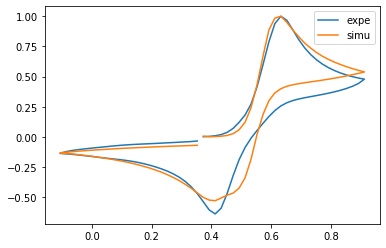

In [4]:
guess=(5.55824144e-01, 4.41382398e-01, 9.71843960e-01, 1.00000000e+01,
       1.00000000e-03)
df = pd.read_csv(path, delimiter = ';', decimal = ',')
I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
E_expe_CSV = df['Potential applied (V)'].to_numpy()
I = I_new(guess, *cst_expe_set)
I_simu_CSV = I/max(I)

plt.plot(E_expe_CSV, I_expe_CSV, label = 'expe')
plt.plot(E_expe_CSV, I_simu_CSV, label = 'simu')
plt.legend()
plt.show()

In [5]:
guess=(5.55824144e-01, 4.41382398e-01, 9.71843960e-01, 1.00000000e+01,
       1.00000000e-04)
fit_experimental_data('Che207 Ni(BinapSQ) 500mV s.txt', guess)

DM =  0.45 and lambda =  50
0.5327664529241967
DM =  0.45 and lambda =  50
0.5327664529241967
DM =  0.45 and lambda =  50
0.5327664535183093
DM =  0.45 and lambda =  50
0.5327664529145673
DM =  0.45 and lambda =  50
0.5327664529268294
DM =  0.45 and lambda =  50
0.5327664528638121
DM =  0.45 and lambda =  50
0.5327664529241967
DM =  0.45 and lambda =  50
1.1997155204103642
DM =  0.45 and lambda =  50
0.5465698733347764
DM =  0.45 and lambda =  50
0.5328881618022707
DM =  0.45 and lambda =  50
0.5327662228659193


     fun: 0.5327662228659193
     jac: array([ 0.03987022, -0.00064622,  0.00017668, -0.00405234,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([5.55784274e-01, 4.41383044e-01, 9.71843783e-01, 1.00000041e+01,
       1.00000000e-04])

DM =  0.45 and lambda =  50


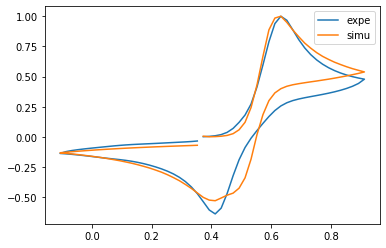

In [8]:
found_guess_2 = (5.55784274e-01, 4.41383044e-01, 9.71843783e-01, 1.00000041e+01,
       1.00000000e-04)


I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
E_expe_CSV = df['Potential applied (V)'].to_numpy()
I = I_new(found_guess_2, *cst_expe_set)
I_simu_CSV = I/max(I)

plt.plot(E_expe_CSV, I_expe_CSV, label = 'expe')
plt.plot(E_expe_CSV, I_simu_CSV, label = 'simu')
plt.legend()
plt.show()



DM =  0.45 and lambda =  50


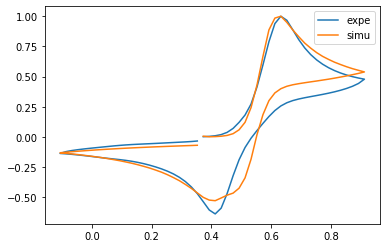

In [7]:
found_guess_2 = (5.55834655e-01, 4.41369917e-01, 9.71844851e-01, 1.00000494e+01,
       1.00000000e-03)


I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
E_expe_CSV = df['Potential applied (V)'].to_numpy()
I = I_new(found_guess_2, *cst_expe_set)
I_simu_CSV = I/max(I)

plt.plot(E_expe_CSV, I_expe_CSV, label = 'expe')
plt.plot(E_expe_CSV, I_simu_CSV, label = 'simu')
plt.legend()
plt.show()


In [ ]:
found_guess_1 = (5.55824144e-01, 4.41382398e-01, 9.71843960e-01, 1.00000000e+01,
       1.00000000e-03)
I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
E_expe_CSV = df['Potential applied (V)'].to_numpy()
I = I_new(found_guess, *cst_expe_set)
I_simu_CSV = I/max(I)

plt.plot(E_expe_CSV, I_expe_CSV, label = 'expe')
plt.plot(E_expe_CSV, I_simu_CSV, label = 'simu')
plt.legend()
plt.show()

In [19]:
df = pd.read_csv(path, delimiter = ';', decimal = ',')

In [20]:
df['Potential applied (V)']

,Potential applied (V),Time (s),WE(1).Current (A),Scan,Index,Q+,Q-,Current range
0,0.372467,12.861095,1.199341e-08,1,1,0.000005,-0.000003,10 µA
1,0.392456,12.901073,3.094482e-08,1,2,0.000005,-0.000003,10 µA
2,0.412445,12.941051,6.311035e-08,1,3,0.000005,-0.000003,10 µA
3,0.432434,12.981029,1.256104e-07,1,4,0.000005,-0.000003,10 µA
4,0.452423,13.021007,2.459106e-07,1,5,0.000005,-0.000003,10 µA
...,...,...,...,...,...,...,...,...
97,0.272522,16.738961,-2.991943e-07,1,98,0.000005,-0.000003,10 µA
98,0.292511,16.778939,-2.827759e-07,1,99,0.000005,-0.000003,10 µA
99,0.312500,16.818917,-2.661438e-07,1,100,0.000005,-0.000003,10 µA
100,0.332489,16.858895,-2.461853e-07,1,101,0.000005,-0.000003,10 µA
